In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mpld3

%matplotlib inline
mpld3. enable_notebook()

In [2]:
def ode_Euler(f, x0, tspan):
    """
    Args:
     
     inputs:
        f: A function : x -> x_dot
        x0: init value of x
        tspan: a n-d array, from t0 to t_end
     
     outputs:
        x: a n-d array: [x0, x1, x2, ... , xn]
        
    """
    n = tspan.size
    delta_t = (tspan[-1] - tspan[0])/n
    xs = np.zeros([n, len(x0)])
    xs[0] = x0
    for i in range(1, n):
        xs[i] = xs[i-1] + np.array(f(xs[i-1]))*delta_t
    return xs

def ode_RK(f, x0, tspan):
    """
    Args:
     
     inputs:
        f: A function : x -> x_dot
        x0: init value of x
        tspan: a n-d array, from t0 to t_end
     
     outputs:
        x: a n-d array: [x0, x1, x2, ... , xn]
        
    """
    n = tspan.size
    h = (tspan[-1] - tspan[0])/n
    xs = np.zeros([n, len(x0)])
    xs[0] = x0
    alpha = 2/3
    Beta2 = 1 / (2*alpha)
    Beta1 = 1 - Beta2
    for i in range(1, n):
        k1 = f(xs[i-1])
        k2 = f(xs[i-1] + alpha*h*k1)
        xs[i] = xs[i-1] + (Beta1*k1 + Beta2*k2)*h
    return xs

In [3]:

def plot_PhasePortrait(f, x0, x1, axes ,lim):
    X0, X1 = np.meshgrid(x0, x1)
    X_dot0, X_dot1 = np.zeros(X0.shape), np.zeros(X1.shape)
    NI, NJ = X0.shape
    
    for i in range(NI):
        for j in range(NJ):
            X_dot = f([X0[i, j], X1[i, j]])
            X_dot0[i, j] = X_dot[0]
            X_dot1[i, j] = X_dot[1]

    Q = axes.quiver(X0, X1, X_dot0, X_dot1, color='r')
    axes.set_xlabel('$x$')
    axes.set_ylabel('$\dot{x}$')
    axes.set_xlim(lim[0])
    axes.set_ylim(lim[1])

### Motion Policy

>A motion policy is a map $\mathbf{\pi}: \mathbf{y},\mathbf{\dot{y}} \rightarrow \mathbf{\ddot{y}}$ from position and velocity to acceleration

In [5]:
def policy(y, dot_y):
    return -np.sin(y)

#to plot phase portrait, we use state space representation
def f(x):
    """
    x = [y, y_dot]
    
    output:
        x_dot = [y_dot, y_ddot]
    """
    return np.array([x[1], policy(x[0], x[1])])

#### A 1-D simple mechanical system
$$
\ddot{\mathbf{y}} + \sin(\mathbf{y}) = 0
$$

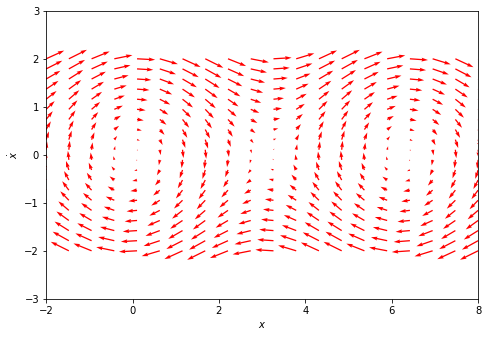

In [8]:
y = np.linspace(-2.0, 8.0, 20)
y_dot = np.linspace(-2.0, 2.0, 20)


fig = plt.figure() 
axes = fig.add_axes([0, 0, 1, 1])
axes_limit = [[-2,8], [-3, 3]]

plot_PhasePortrait(f, y, y_dot, axes, axes_limit)

### Trajectory Generation Through ODE solver
- Runge-Kutta method

(-3, 3)

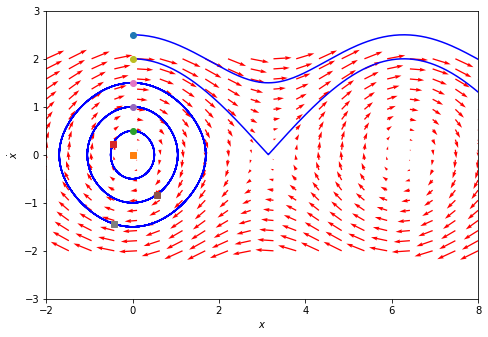

In [9]:
fig = plt.figure() 
axes = fig.add_axes([0, 0, 1, 1])
axes_limit = [[-2,8], [-3, 3]]

plot_PhasePortrait(f, y, y_dot, axes, axes_limit)
for y_ddot0 in [0, 0.5, 1, 1.5, 2, 2.5]:
    tspan = np.linspace(0, 50, 2000)
    x0 = [0.0, y_ddot0]
    ys = ode_RK(f, x0, tspan)
    axes.plot(ys[:,0], ys[:,1], 'b-') # path
    axes.plot([ys[0,0]], [ys[0,1]], 'o') # start
    axes.plot([ys[-1,0]], [ys[-1,1]], 's') # end
    
axes.set_xlim([-2, 8])
axes.set_ylim([-3, 3])
#plt.savefig('images/phase-portrait-2.png')

- Euler forward method

(-3, 3)

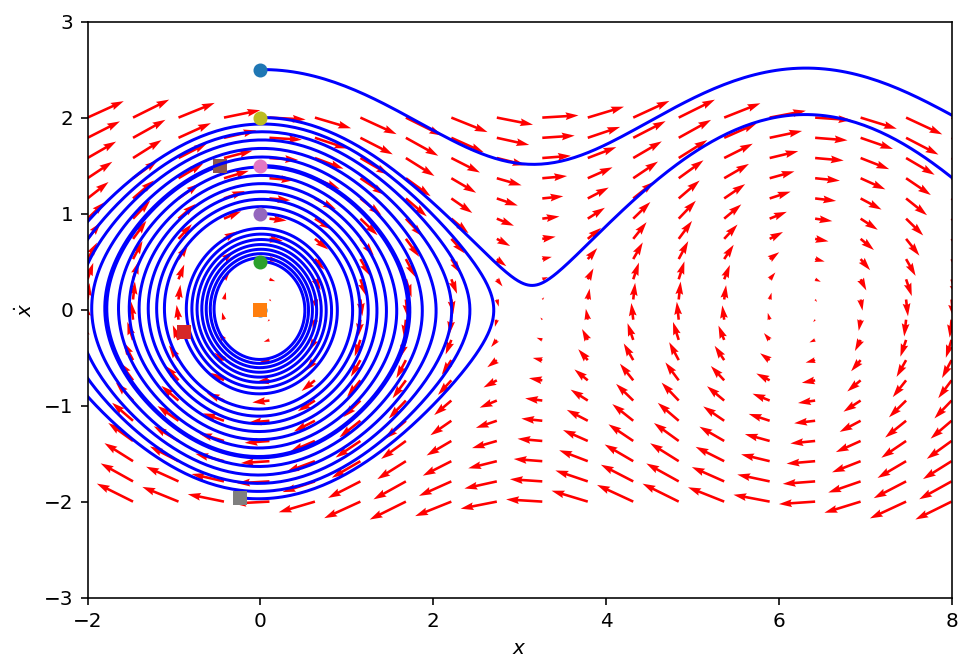

In [7]:
fig = plt.figure() 
axes = fig.add_axes([0, 0, 1, 1])
axes_limit = [[-2,8], [-3, 3]]

plot_PhasePortrait(f, y, y_dot, axes, axes_limit)
for y_ddot0 in [0, 0.5, 1, 1.5, 2, 2.5]:
    tspan = np.linspace(0, 50, 2000)
    x0 = [0.0, y_ddot0]
    ys = ode_Euler(f, x0, tspan)
    axes.plot(ys[:,0], ys[:,1], 'b-') # path
    axes.plot([ys[0,0]], [ys[0,1]], 'o') # start
    axes.plot([ys[-1,0]], [ys[-1,1]], 's') # end
    
axes.set_xlim([-2, 8])
axes.set_ylim([-3, 3])
#plt.savefig('images/phase-portrait-2.png')

As we shall see, the naive forward Euler method leads to numerical method which may cause divergence of the system 



---

Now consider Riemannian Motion Policy 
that avoid obstacle

Designed Geometry Dynamic System:
$$
(G(x, \dot{x}) + \Xi_G)\ddot{x} + \xi_G = -B\dot{x} - \nabla_x\phi(x)
$$
on the 1-d manifold with a coordinate $x = d(q)$, where 
$d$ is a distance function


1. design $G(x, \dot{x})$

here we choose 
$$
    G(x, \dot{x})=w(x)u(\dot{x}) > 0 \\
    w(x) = \frac{1}{x^4} \\
    u(\dot{x}) = min(0, \dot{x})\dot{x} + \epsilon 
$$


In [46]:
def RMP_obs(alpha, eps, x, x_dot):
    if(x_dot) > 0:
        x_ddot = (4*alpha) / (eps*(x**5))
    else:
        x_ddot = 2*(x**4*x_dot**4 + 2*alpha) / ((2*x_dot + eps)* x**5)
    return x_ddot


alpha = 1
eps = 1
def f(x):
    return np.array([x[1], RMP_obs(alpha, eps, x[0], x[1])])


__main__:5: RuntimeWarning: divide by zero encountered in double_scalars
__main__:3: RuntimeWarning: divide by zero encountered in double_scalars


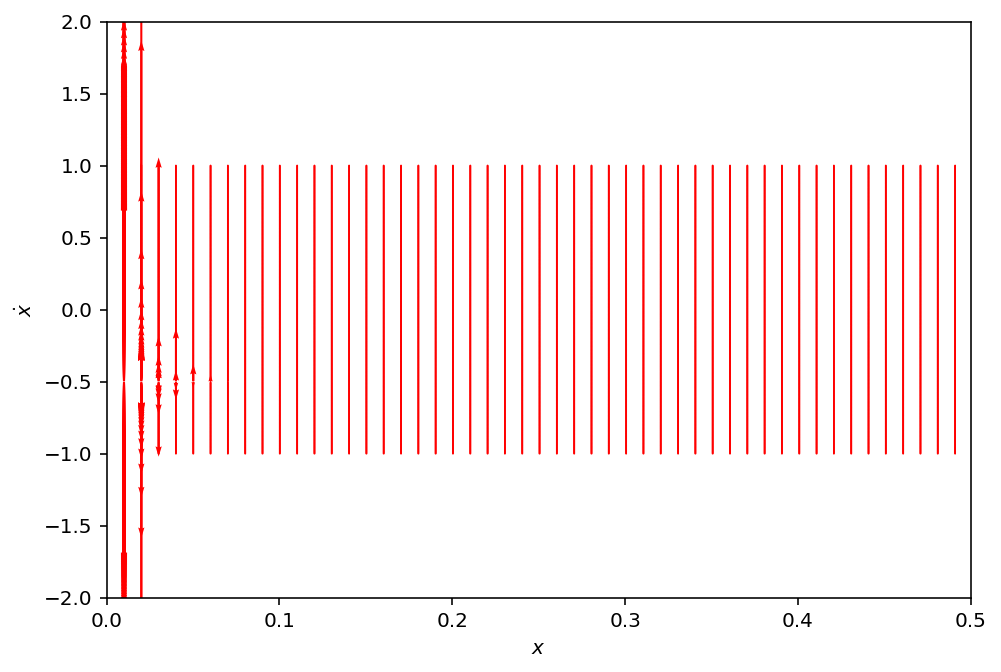

In [47]:
x = np.linspace(0, 5, 500)
x_dot = np.linspace(-1.0, 1.0, 500)
fig = plt.figure() 
axes = fig.add_axes([0, 0, 1, 1])
axes_limit = [[0,0.5], [-2, 2]]

plot_PhasePortrait(f, x, x_dot, axes, axes_limit)